In [1]:
# Mathematical operations and statistical tools
import numpy as np
from scipy import stats, spatial

# Optimal transport
try:
    import ot
except ModuleNotFoundError:
    !pip install POT
    import ot

# Deep learning library
import torch

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Typing
from typing import Union, Callable, List, Optional

import warnings
warnings.filterwarnings('ignore')

We fix the numpy random seed and the device (the code can be run on CPU in a reasonable amount of time).

In [2]:
np.random.seed(44)
torch.manual_seed(44);

The following class allows to build a dataset from two distributions. This will be used to train out models.

In [3]:
class RandomDataset(torch.utils.data.Dataset):
    """Creates a dataset of `size` samples from two distributions."""
    def __init__(
        self,
        mu: Union[stats.rv_continuous, stats.rv_discrete],
        nu: Union[stats.rv_continuous, stats.rv_discrete],
        size: int = 2_000
    ):
        xs = mu.rvs(size=size)
        ys = nu.rvs(size=size)
        self.xs = torch.from_numpy(xs).reshape((size, -1))
        self.ys = torch.from_numpy(ys).reshape((size, -1))

    def __len__(self):
        return self.xs.shape[0]
      
    def __getitem__(self, idx: int):
        return dict(
            origin = self.xs[idx,...],
            target = self.ys[idx,...]
        )

# 1. Univariate gaussians with the same variance
$$
    \mu = \mathcal{N}_1(-2, 1) \quad \nu = \mathcal{N}_1(2, 1)
$$

The optimal map is 
$$
    T \colon x \to x+4
$$

And hence the cost of this map is
$$
    W_1(\mu, \nu) = \int_\mathbb{R} |x-T(x)|d\mu(x) = \int_\mathbb{R} 4d\mu(x) = 4
$$

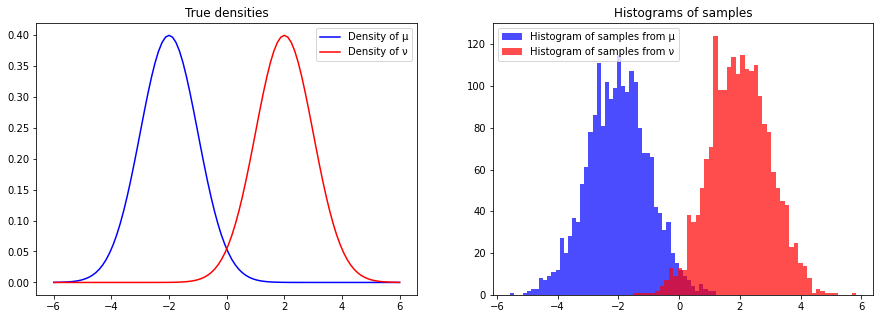

In [4]:
mu = stats.norm(-2, 1)
nu = stats.norm(2, 1)
    
dataset = RandomDataset(mu, nu)

fig, (left, right) = plt.subplots(1, 2, figsize=(15,5))
ticks = np.linspace(-6, 6, 100)
densite_mu = np.vectorize(mu.pdf)(ticks)
densite_nu = np.vectorize(nu.pdf)(ticks)
left.plot(ticks, densite_mu, color='blue', label='Density of μ')
left.plot(ticks, densite_nu, color='red', label='Density of ν')
right.hist(dataset.xs.detach().numpy(), bins=50, color='blue', alpha=.7, label='Histogram of samples from μ')
right.hist(dataset.ys.detach().numpy(), bins=50, color='red', alpha=.7, label='Histogram of samples from ν')
left.legend()
right.legend()
left.set_title("True densities")
right.set_title("Histograms of samples");

## 1.1. Approximation with a neural network

To approximate $W_1$ with a neural network, we use its dual representation 

\begin{align*}
    W_1(\mu,\nu) & = \sup_{f \in \text{Lip}_1(\mathbb{R},\mathbb{R})}  \int_\mathbb{R} f d(\mu-\nu) \\
    & = \sup_{f \in \text{Lip}_1(\mathbb{R},\mathbb{R})} \mathbb{E}_{(x,y)\sim\mu\otimes\nu}[f(x)-f(y)]
\end{align*}

To this end, we approximate :
- the expectation with the empirical mean from a sample from the distribution $\mu\otimes\nu$ ;
- and the function $f$ by a feed-forward neural network (to enforce the Lipschitz constraint, we apply spectral normalization on the linear layers).

In [5]:
def train(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    nb_epochs: int = 100,
    verbose: bool = True,
):
    losses = []

    for epoch in range(nb_epochs):
        model.train()
        train_loss = 0.0

        for batch in dataloader:
            optimizer.zero_grad()

            x = batch['origin'].float()
            y = batch['target'].float()
            fx = model(x)
            fy = model(y)

            loss = torch.sum(fx - fy)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

        # Print loss ~10 times
        if verbose and (epoch+1)%(nb_epochs//10) == 0: print(f'Epoch {epoch+1}/{nb_epochs}, training loss: {train_loss/len(dataloader)/100:.4g}')
        losses.append(train_loss/len(dataloader)/100)
    
    return losses


def plot_progress(losses: List[float], title:Optional[str]=None):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.plot(losses, color='blue')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Estimation')
    if title is not None:
        ax.set_title(title)

Epoch 15/150, training loss: 3.826
Epoch 30/150, training loss: 3.947
Epoch 45/150, training loss: 3.986
Epoch 60/150, training loss: 4
Epoch 75/150, training loss: 4.004
Epoch 90/150, training loss: 4.006
Epoch 105/150, training loss: 4.006
Epoch 120/150, training loss: 4.006
Epoch 135/150, training loss: 4.006
Epoch 150/150, training loss: 4.006
W_1 ≈ 4.006


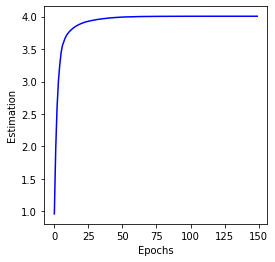

In [6]:
from torch.nn.utils.parametrizations import spectral_norm # To enforce the 1-Lipschitz constraint

def wasserstein_gan(
    dataset: torch.utils.data.Dataset,
    verbose: bool = True
):
    model = torch.nn.Sequential(
        spectral_norm(torch.nn.Linear(1, 8)),
        torch.nn.ReLU(),
        spectral_norm(torch.nn.Linear(8, 8)),
        torch.nn.ReLU(),
        spectral_norm(torch.nn.Linear(8, 1)),
    )

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, drop_last=True, shuffle=True)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, maximize=True)

    losses = train(
        model = model,
        dataloader = dataloader,
        optimizer = optimizer,
        nb_epochs = 150,
        verbose = verbose
    )
    if verbose: plot_progress(losses)
    return np.max(losses)

res = wasserstein_gan(dataset)
print(f"W_1 ≈ {res:.3f}")

The estimated Wasserstein distance is the opposite of the loss of the trained model, i.e. 
$$
    \hat W_1^N(\hat\mu_n, \hat\nu_n) \approx 4.006
$$

In this case the relative error is 0.15\%. Let us now compare it to a standard OT algorithm: the Sinkhorn algorithm.

# 1.2. Approximation with the Sinkhorn algorithm 

The Sinkhorn algorithm solves the following problem

$$
    P^*(\gamma) = \arg\min_P \langle P, C \rangle + \gamma E(P)
$$

where $C$ is the cost matrix between the samples defined by 

$$
    C_{i,j} = |x_i - y_j |
$$

$\gamma$ is a regularization hyperparameter and $E(P)$ is the entropy of $P$ :       

$$
    E(P) = \sum_{i,j} P_{i,j}\log(P_{i,j})
$$

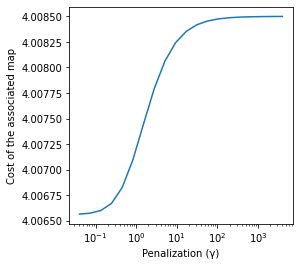

In [7]:
def solve_sinkhorn(xs, ys, log_gamma_min=-2, log_gamma_max=3, verbose=True):
    C = spatial.distance.cdist(
        xs, ys,
        metric = 'cityblock'
    )

    results = []
    gammas = np.logspace(log_gamma_min, log_gamma_max, 20)
    c_mean = np.mean(C)
    for gamma in gammas:
        P = ot.bregman.sinkhorn([], [], C, reg=gamma*c_mean)
        results.append(np.sum(C*P))

    if verbose:
        fig, ax = plt.subplots(figsize=(4,4))
        ax.plot(gammas*c_mean, results)
        ax.set_xscale('log')
        ax.set_xlabel('Penalization (γ)')
        ax.set_ylabel('Cost of the associated map')

    return results

results = solve_sinkhorn(dataset.xs, dataset.ys)

With an appropriate choice of $\gamma = 10^{-2}$, we obtain 

$$
    \hat W_1^S(\hat\mu_n, \hat\nu_n) \approx 4.007
$$

In this particular case, both methods approximate very well the true 1-Wasserstein distance.

## 1.3. Comparison with different parameters

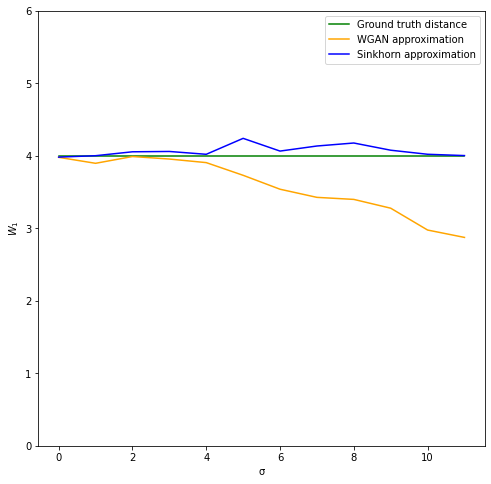

In [8]:
def compare_gaussian(mean_1=-2, mean_2=2, sigma_min=1, sigma_max=12):
    wgans = []
    sinkhorns = []
    ground_truths = []

    for sigma in np.linspace(sigma_min, sigma_max, 12):
        mu = stats.norm(mean_1, sigma)
        nu = stats.norm(mean_2, sigma)
        dataset = RandomDataset(mu, nu)
        ground_truth_w1 = np.abs(mean_2-mean_1)

        wgan_approx = wasserstein_gan(dataset, verbose=False)
        sinkhorn_approxs = solve_sinkhorn(dataset.xs, dataset.ys, verbose=False)
        best_sinkhorn_approx = sinkhorn_approxs[np.argmin(np.abs(sinkhorn_approxs-ground_truth_w1))]

        ground_truths.append(ground_truth_w1)
        wgans.append(wgan_approx)
        sinkhorns.append(best_sinkhorn_approx)
    
    fig, ax = plt.subplots(figsize=(8,8))
    wgans = np.array(wgans)
    sinkhorns = np.array(sinkhorns)
    ground_truths = np.array(ground_truths)
    ax.plot(ground_truths, color='green', label='Ground truth distance')
    ax.plot(wgans, color='orange', label="WGAN estimation")
    ax.plot(sinkhorns, color='blue', label="Sinkhorn estimation")
    ax.set_xlabel("σ")
    ax.set_ylabel(r"$W_1$")
    ax.set_ylim(ymin=0, ymax=6)
    ax.legend()
    fig.show()

    return wgans, sinkhorns

wgans, sinkhorns = compare_gaussian()

# 2. Exponential distributions

$$
    \mu = \mathcal{E}(\kappa) \quad \nu = \mathcal{E}(\lambda)
$$

where $ \kappa \geq \lambda$ are *scale* parameters. To compute the Wassertstein distance, we use the following representation :

\begin{align*}
    W_1(\mu, \nu) & = \int_\mathbb{R} |F_\mu(t) - F_\nu(t)| dt \\ 
    & = \int_\mathbb{R_+} | 1 - e^{-t/\kappa} - (1 - e^{-t/\lambda}) | dt \\
    & = \int_\mathbb{R_+} (e^{-t/\kappa} - e^{-t/\lambda}) dt \\
    & = \left[ \lambda e^{-t/\lambda} - \kappa e^{-t/\kappa}\right]_{t=0}^\infty \\
    & = \kappa - \lambda
\end{align*}

In the following experiment, we consider $\kappa = 3$ and $\lambda = 1$, so

$$
    W_1(\mu,\nu) = 2
$$

Epoch 10/100, training loss: 1.85
Epoch 20/100, training loss: 1.999
Epoch 30/100, training loss: 2.016
Epoch 40/100, training loss: 2.017
Epoch 50/100, training loss: 2.017
Epoch 60/100, training loss: 2.017
Epoch 70/100, training loss: 2.017
Epoch 80/100, training loss: 2.017
Epoch 90/100, training loss: 2.017
Epoch 100/100, training loss: 2.017
W_1 ≈ 2.017


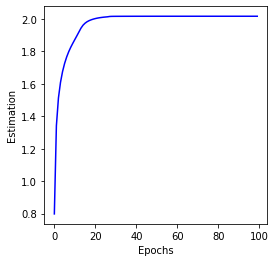

In [8]:
def wgan_expo(mu, nu):
    mu = stats.expon(mu)
    nu = stats.expon(nu)
    dataset = RandomDataset(mu, nu)
    
    model = torch.nn.Sequential(
        spectral_norm(torch.nn.Linear(1, 8)),
        torch.nn.ReLU(),
        spectral_norm(torch.nn.Linear(8, 8)),
        torch.nn.ReLU(),
        spectral_norm(torch.nn.Linear(8, 1)),
    )
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, drop_last=True, shuffle=True)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, maximize=True)
    return dataset, model, dataloader, optimizer

dataset, model, dataloader, optimizer = wgan_expo(3, 1)
    
losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)
print(f"W_1 ≈ {np.max(losses):.3f}")

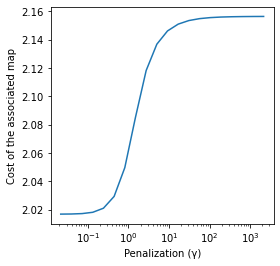

In [9]:
results = solve_sinkhorn(dataset.xs, dataset.ys)

We obtain
$$
    \hat W_1^N(\hat\mu_n, \hat\nu_n) \approx 2.07
$$

and 

$$
    \hat W_1^S(\hat\mu_n, \hat\nu_n) \approx 2.07
$$

Again, both methods provide a similar approximation.

## Comparison with other parameters

In the following experiment, we consider $\kappa = 0.5$ and $\lambda = 1$, so

$$
    W_1(\mu,\nu) = 0.5
$$

Epoch 10/100, training loss: 0.4405
Epoch 20/100, training loss: 0.4997
Epoch 30/100, training loss: 0.5211
Epoch 40/100, training loss: 0.5277
Epoch 50/100, training loss: 0.5288
Epoch 60/100, training loss: 0.5288
Epoch 70/100, training loss: 0.5288
Epoch 80/100, training loss: 0.5288
Epoch 90/100, training loss: 0.5288
Epoch 100/100, training loss: 0.5288


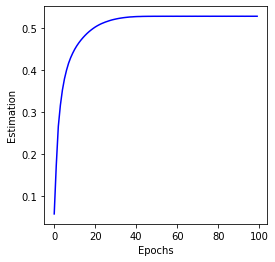

In [11]:
dataset, model, dataloader, optimizer = wgan_expo(1/2, 1)
    
losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)

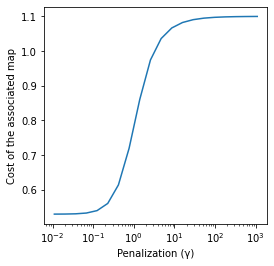

In [12]:
results = solve_sinkhorn(dataset.xs, dataset.ys)

In the following experiment, we consider $\kappa = 5$ and $\lambda = 1$, so

$$
    W_1(\mu,\nu) = 4
$$

Epoch 10/100, training loss: 3.519
Epoch 20/100, training loss: 3.902
Epoch 30/100, training loss: 3.975
Epoch 40/100, training loss: 3.978
Epoch 50/100, training loss: 3.978
Epoch 60/100, training loss: 3.979
Epoch 70/100, training loss: 3.979
Epoch 80/100, training loss: 3.979
Epoch 90/100, training loss: 3.979
Epoch 100/100, training loss: 3.979
W_1 ≈ 3.979


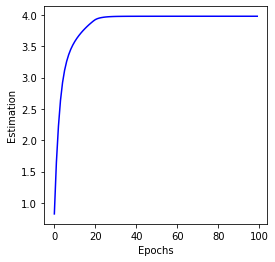

In [14]:
dataset, model, dataloader, optimizer = wgan_expo(5, 1)
    
losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)
print(f"W_1 ≈ {np.max(losses):.3f}")

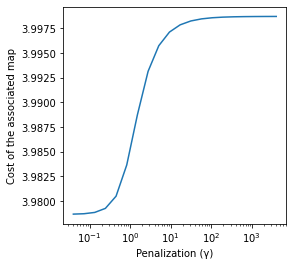

In [15]:
results = solve_sinkhorn(dataset.xs, dataset.ys)

In the following experiment, we consider $\kappa = 5$ and $\lambda = 2$, so

$$
    W_1(\mu,\nu) = 3
$$

Epoch 10/100, training loss: 2.818
Epoch 20/100, training loss: 2.913
Epoch 30/100, training loss: 2.967
Epoch 40/100, training loss: 2.968
Epoch 50/100, training loss: 2.968
Epoch 60/100, training loss: 2.968
Epoch 70/100, training loss: 2.968
Epoch 80/100, training loss: 2.968
Epoch 90/100, training loss: 2.968
Epoch 100/100, training loss: 2.968
W_1 ≈ 2.968


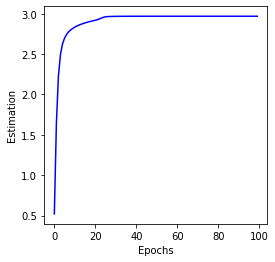

In [17]:
dataset, model, dataloader, optimizer = wgan_expo(5, 2)
    
losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)
print(f"W_1 ≈ {np.max(losses):.3f}")

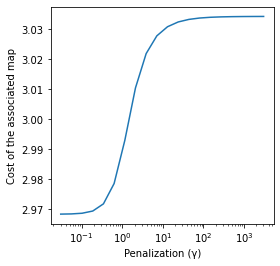

In [18]:
results = solve_sinkhorn(dataset.xs, dataset.ys)

# 3. Geometric distributions

With $\mu \sim \mathcal G\left(\frac12\right)$ and $\nu \sim \mathcal G\left(\frac14\right)$, we have

$$ W_1(\mu,\nu) = \frac1q - \frac1p = 4 - 2 = 2 $$

Epoch 10/100, training loss: 1.995
Epoch 20/100, training loss: 2.065
Epoch 30/100, training loss: 2.086
Epoch 40/100, training loss: 2.094
Epoch 50/100, training loss: 2.096
Epoch 60/100, training loss: 2.096
Epoch 70/100, training loss: 2.096
Epoch 80/100, training loss: 2.096
Epoch 90/100, training loss: 2.096
Epoch 100/100, training loss: 2.096
W_1 ≈ 2.096


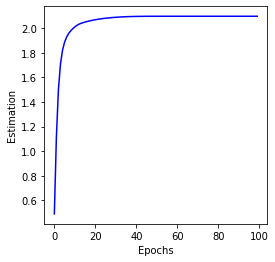

In [23]:
def wgan_geo(mu, nu):
    mu = stats.geom(mu)
    nu = stats.geom(nu)
    dataset = RandomDataset(mu, nu)
    
    model = torch.nn.Sequential(
        spectral_norm(torch.nn.Linear(1, 8)),
        torch.nn.ReLU(),
        spectral_norm(torch.nn.Linear(8, 8)),
        torch.nn.ReLU(),
        spectral_norm(torch.nn.Linear(8, 1)),
    )
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, drop_last=True, shuffle=True)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, maximize=True)
    return dataset, model, dataloader, optimizer

dataset, model, dataloader, optimizer = wgan_geo(1/2, 1/4)
losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)
print(f"W_1 ≈ {np.max(losses):.3f}")

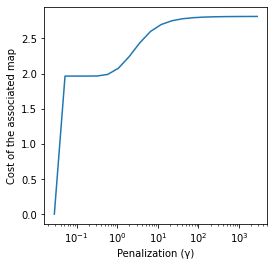

In [21]:
results = solve_sinkhorn(dataset.xs, dataset.ys)

## Comparison with other parameters

In the following experiment, we consider $q = 1/8$ and $p = 1/4$, so

$$
    W_1(\mu,\nu) = 4
$$

Epoch 10/100, training loss: 3.94
Epoch 20/100, training loss: 3.991
Epoch 30/100, training loss: 4.001
Epoch 40/100, training loss: 4.001
Epoch 50/100, training loss: 4.001
Epoch 60/100, training loss: 4.001
Epoch 70/100, training loss: 4.001
Epoch 80/100, training loss: 4.001
Epoch 90/100, training loss: 4.001
Epoch 100/100, training loss: 4.001
W_1 ≈ 4.001


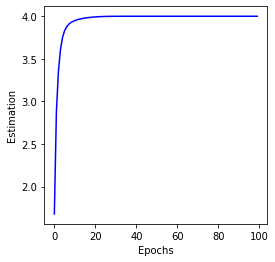

In [28]:
dataset, model, dataloader, optimizer = wgan_geo(1/8, 1/4)
losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)
print(f"W_1 ≈ {np.max(losses):.3f}")

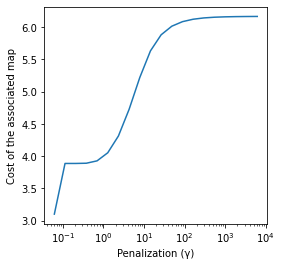

In [25]:
results = solve_sinkhorn(dataset.xs, dataset.ys)

In the following experiment, we consider $q = 1/3$ and $p = 1/5$, so

$$
    W_1(\mu,\nu) = 2
$$

Epoch 10/100, training loss: 1.883
Epoch 20/100, training loss: 1.971
Epoch 30/100, training loss: 2.002
Epoch 40/100, training loss: 2.012
Epoch 50/100, training loss: 2.013
Epoch 60/100, training loss: 2.013
Epoch 70/100, training loss: 2.013
Epoch 80/100, training loss: 2.013
Epoch 90/100, training loss: 2.013
Epoch 100/100, training loss: 2.013
W_1 ≈ 2.013


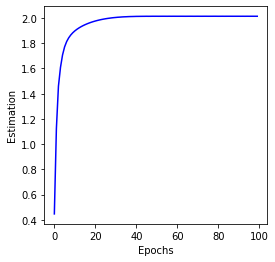

In [29]:
dataset, model, dataloader, optimizer = wgan_geo(1/3, 1/5)
losses = train(model, dataloader, optimizer, nb_epochs=100)
plot_progress(losses)
print(f"W_1 ≈ {np.max(losses):.3f}")

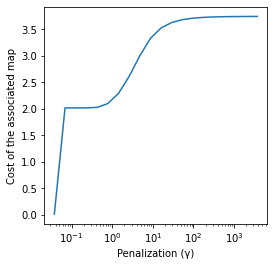

In [30]:
results = solve_sinkhorn(dataset.xs, dataset.ys)